### Josh Barrios
Deep CNN for ECG/PCW regression

In [13]:
#imports
from __future__ import division, print_function, absolute_import


import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
import tensorflow as tf
import random, math
import sys, os, time, json
import scipy.interpolate as interp 
import csv 
import copy
import timeit
import pandas as pd
import re
import pdb
import traceback
from tqdm import tqdm

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

os.environ['CUDA_VISIBLE_DEVICES'] = "2"

In [8]:
%load_ext watermark
%watermark

2020-11-25T22:34:05+00:00

CPython 3.5.2
IPython 7.1.1

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 3.10.0-693.21.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 48
interpreter: 64bit


In [9]:
%watermark  --iversions

json       2.0.9
tensorflow 1.12.0
numpy      1.15.4
pandas     0.23.4
re         2.2.1
csv        1.0



In [10]:
ecg_directory = '/volume/ECG/pcw_regression/run1_ph_csvs'
file_dict = {}
fail = []

for filename in tqdm(os.listdir(ecg_directory)):
    name = filename[:-4]
    if name not in file_dict.keys():
        try:
            file_dict[name] = [-1,1]
            ecg_raw = np.loadtxt(ecg_directory + '/' + filename, skiprows=1, delimiter=',', usecols=range(12))
            len_leads = len(ecg_raw)
            if len_leads == 5000:
                file_dict[name][0] = ecg_raw[::2]
            elif len_leads == 2500:
                file_dict[name][0] = ecg_raw
            else:
                print('len_leads:', len_leads)
        except:
            fail.append(filename)

print('Failed to find:', fail)
print('Num ECGS extracted:',len(file_dict))
np.save('an7_v1.npy',file_dict)

100%|██████████| 2344/2344 [02:05<00:00, 18.70it/s]


Failed to find: []
Num ECGS extracted: 2344


In [12]:
def load_data(lab_value):
#     ecg_directory = '/gunvant_nas_trop/ecgs/%s' % lab_value
#     file_dict = {}
#     fail = []
    
#     for filename in tqdm(os.listdir(ecg_directory)):
#         name = filename[:-4]
#         if name not in file_dict.keys():
#             try:
# #                 pdb.set_trace()
#                 file_dict[name] = [-1,1]
#                 ecg_raw = np.loadtxt(ecg_directory + '/' + filename, skiprows=1, delimiter=',', usecols=range(12))
#                 len_leads = len(ecg_raw)
#                 if len_leads == 5000:
#                     file_dict[name][0] = ecg_raw[::2]
#                 elif len_leads == 2500:
#                     file_dict[name][0] = ecg_raw
#                 else:
#                     print('len_leads:', len_leads)
#             except:
#                 fail.append(filename)
# #         if len(file_dict)>100:
# #             break;

#     print('Failed to find:', fail)
#     print('Num ECGS extracted:',len(file_dict))
#     np.save('ef.npy',file_dict)

    file_dict = np.load('an7_v1.npy',allow_pickle=True,encoding='latin1')
    file_dict = file_dict.item()

    train_voltages = []
    train_labels = []
    val_voltages = []
    val_labels = []
    test_voltages = []
    test_labels = []
    
    train_labels_cat = []
    val_labels_cat = []
    test_labels_cat = []
    
    lab_values = pd.read_csv('/volume/ECG/pcw_regression/run1_uu_mrn.csv')

    mrns = lab_values['mrn'].drop_duplicates()
    lab_values = lab_values.set_index('UUID')
    mrn_train,mrn_not_train = train_test_split(mrns,test_size=0.3, random_state = 111)
    mrn_val, mrn_test = train_test_split(mrn_not_train,test_size=0.6667, random_state = 111)
    
    CUTOFFS = [0, 30, 100]
    
    train_dems = [] # [gender, age, weight, height, bsa]
    val_dems = []
    test_dems = []
    
    
    failed = []
    excluded = []
    for mrn in tqdm(mrn_train.values):
        for key in lab_values[lab_values['mrn'] == mrn].index:
            try:
                label = float(lab_values.loc[key,'disease'])
    #             this_hr = get_hr(file_dict[key][0])
    #             if not math.isnan(this_hr):
                if label>0.0:

    #                 this_vec = []
    #                 this_gen = lab_values.loc[[key],'Gender_y'][0]
    #                 if this_gen == 'Female':
    #                     this_vec.append(0)
    #                 else:
    #                     this_vec.append(1)

    #                 this_vec.append(lab_values.loc[[key],'age'][0])
    #                 this_vec.append(lab_values.loc[[key],'WeightKG'][0])
    #                 this_vec.append(lab_values.loc[[key],'HeightCM'][0])
    #                 this_vec.append(lab_values.loc[[key],'BSA'][0])

    #                 train_dems.append(this_vec)

    #                 if label<=0.1:
    #                     label=0.1
                    train_voltages.append(file_dict[key][0])


                    train_labels.append([label])
                    for ii in range(1, len(CUTOFFS)):
                        if label<CUTOFFS[ii] and label>=CUTOFFS[ii-1]:
                            train_labels_cat.append(ii-1)

    #                 train_labels.append(class_vec)

    #                 train_labels_cat.append([label])
    #                 train_labels.append(this_hr)
                else:
                    excluded.append(key)
    #                 pdb.set_trace() 
                    pass
            except:
                failed.append(key)
    #             traceback.print_exc()
    #             pdb.set_trace() 
                pass
    
    for mrn in tqdm(mrn_val.values):
        for key in lab_values[lab_values['mrn'] == mrn].index:
            try:
                label = float(lab_values.loc[key,'disease'])
    #             this_hr = get_hr(file_dict[key][0])
    #             if not math.isnan(this_hr): 
                if label>=0.0:# or random.random()<0.2:
    #                 this_vec = []
    #                 this_gen = lab_values.loc[[key],'Gender_y'][0]
    #                 if this_gen == 'Female':
    #                     this_vec.append(0)
    #                 else:
    #                     this_vec.append(1)

    #                 this_vec.append(lab_values.loc[[key],'age'][0])
    #                 this_vec.append(lab_values.loc[[key],'WeightKG'][0])
    #                 this_vec.append(lab_values.loc[[key],'HeightCM'][0])
    #                 this_vec.append(lab_values.loc[[key],'BSA'][0])

    #                 val_dems.append(this_vec)

    #                 if label<=0.1:
    #                     label=0.1
                    val_voltages.append(file_dict[key][0])


                    val_labels.append([label])

                    for ii in range(1, len(CUTOFFS)):
                        if label<CUTOFFS[ii] and label>=CUTOFFS[ii-1]:
                            val_labels_cat.append(ii-1)

    #                 val_labels.append(class_vec)

    #                 if label <= CUTOFF:
    #                     val_labels.append([0])
    #                 else:
    #                     val_labels.append([1])
    #                 val_labels_raw.append([label])
    #                 val_labels.append(this_hr)
                else:
                    excluded.append(key)
    #                     pdb.set_trace() 
                    pass
            except:
                failed.append(key)
                pass

    for mrn in tqdm(mrn_test.values):
        for key in lab_values[lab_values['mrn'] == mrn].index:
            try:
                label = float(lab_values.loc[key,'disease'])
    #             this_hr = get_hr(file_dict[key][0])
    #             if not math.isnan(this_hr):
                if label>=0.0:# or random.random()<0.2:

    #                 this_vec = []
    #                 this_gen = lab_values.loc[[key],'Gender_y'][0]
    #                 if this_gen == 'Female':
    #                     this_vec.append(0)
    #                 else:
    #                     this_vec.append(1)

    #                 this_vec.append(lab_values.loc[[key],'age'][0])
    #                 this_vec.append(lab_values.loc[[key],'WeightKG'][0])
    #                 this_vec.append(lab_values.loc[[key],'HeightCM'][0])
    #                 this_vec.append(lab_values.loc[[key],'BSA'][0])

    #                 test_dems.append(this_vec)


    #                 if label<=0.1:
    #                     label=0.1
                    test_voltages.append(file_dict[key][0])

                    test_labels.append([label])

                    for ii in range(1, len(CUTOFFS)):
                        if label<CUTOFFS[ii] and label>=CUTOFFS[ii-1]:
                            test_labels_cat.append(ii-1)

    #                 test_labels.append(class_vec)

    #                 if label <= CUTOFF:
    #                     test_labels.append([0])
    #                 else:
    #                     test_labels.append([1])

    #                 test_labels_cat.append([label])
    #                 test_labels.append(this_hr)
                else:
                    excluded.append(key)
    #                     pdb.set_trace() 
                    pass
            except:
                failed.append(key)
                pass
    
    print('Excluded:', len(excluded))

#     labels_max = 1 # log10(1 + 10)
#     labels_min = -2

#     x_train = np.swapaxes(train_voltages,1,2)
#     x_train = ( ( np.clip(train_voltages, global_min, global_max) - global_min ) / (global_max - global_min) ).reshape((-1,2500,12))
    x_train = np.array(train_voltages)
    pt = PowerTransformer()
    train_labels = np.clip(train_labels,0.01,50)
    pt.fit(train_labels)
    y_train = pt.transform(train_labels)
#     y_train = y_train*2-1
#     y_train = np.array(train_labels)
#     y_train = (np.array(train_labels).reshape((-1,1)) - labels_min) / (labels_max - labels_min)
#     y_train = (np.array(train_labels).reshape((-1,1)) - labels_mean) / (labels_std)

    
#     x_val = np.swapaxes(val_voltages,1,2)
#     x_val = ( ( np.clip(val_voltages, global_min, global_max) - global_min ) / (global_max - global_min) ).reshape((-1,2500,12))
    x_val = np.array(val_voltages)
    val_labels = np.clip(val_labels,0.01,50)
    print(val_labels)
    y_val = pt.transform(val_labels)
    print(y_val)
#     y_val = (np.log10(np.clip(val_labels,0.01,86)) - labels_min) / (labels_max - labels_min)
#     y_val = y_val*2-1
#     y_val = np.array(val_labels)
#     y_val = (np.array(val_labels).reshape((-1,1))  - labels_min) / (labels_max - labels_min)
#     y_val = (np.array(val_labels).reshape((-1,1))  - labels_mean) / (labels_std)

#     x_test = np.swapaxes(test_voltages,1,2)
#     x_test = ( ( np.clip(test_voltages, global_min, global_max) - global_min ) / (global_max - global_min) ).reshape((-1,2500,12))
    x_test = np.array(test_voltages)
    test_labels = np.clip(test_labels,0.01,50)
    y_test = pt.transform(test_labels)
#     y_test = (np.log10(np.clip(test_labels,0.01,86)) - labels_min) / (labels_max - labels_min)
#     y_test = y_test*2-1
#     y_test = np.array(test_labels)
#     y_test = (np.array(test_labels).reshape((-1,1))  - labels_min) / (labels_max - labels_min)
#     y_test = (np.array(test_labels).reshape((-1,1))  - labels_mean) / (labels_std)

    
#     pdb.set_trace() 

    print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, np.array(train_dems).shape, np.array(val_dems).shape, np.array(test_dems).shape)

    return pt, train_labels, x_train, x_val, x_test, y_train, y_val, y_test, np.array(train_dems), np.array(val_dems), np.array(test_dems), train_labels_cat, val_labels_cat, test_labels_cat
    

def get_hr(ecg_raw):
    hrs = []
    _,_,_,_,_,_,hrs = ecg.ecg(signal=ecg_raw[:,1], sampling_rate=250, show=False)
    
    return np.mean(hrs)    

In [14]:
og_pt, train_labels, x_train, x_val, x_test, y_train, y_val, y_test, dems_train, dems_val, dems_test, train_labels_cat, val_labels_cat, test_labels_cat = load_data('sean')

100%|██████████| 470/470 [00:00<00:00, 1490.38it/s]


Excluded: 7
[[30.]
 [21.]
 [11.]
 [12.]
 [12.]
 [16.]
 [ 5.]
 [18.]
 [15.]
 [13.]
 [ 9.]
 [26.]
 [16.]
 [ 6.]
 [26.]
 [30.]
 [ 8.]
 [33.]
 [24.]
 [17.]
 [ 7.]
 [12.]
 [29.]
 [ 8.]
 [20.]
 [13.]
 [31.]
 [14.]
 [19.]
 [16.]
 [14.]
 [20.]
 [10.]
 [ 8.]
 [ 7.]
 [ 1.]
 [ 5.]
 [14.]
 [ 2.]
 [11.]
 [24.]
 [18.]
 [24.]
 [23.]
 [13.]
 [19.]
 [29.]
 [ 5.]
 [10.]
 [17.]
 [13.]
 [11.]
 [22.]
 [10.]
 [20.]
 [ 5.]
 [22.]
 [11.]
 [18.]
 [ 9.]
 [ 5.]
 [32.]
 [14.]
 [12.]
 [ 8.]
 [ 6.]
 [20.]
 [21.]
 [ 4.]
 [19.]
 [16.]
 [19.]
 [17.]
 [10.]
 [19.]
 [11.]
 [13.]
 [ 4.]
 [26.]
 [ 5.]
 [19.]
 [18.]
 [ 8.]
 [15.]
 [12.]
 [ 7.]
 [ 6.]
 [11.]
 [29.]
 [ 8.]
 [ 6.]
 [ 5.]
 [ 5.]
 [ 6.]
 [13.]
 [24.]
 [17.]
 [10.]
 [20.]
 [ 8.]
 [11.]
 [19.]
 [10.]
 [17.]
 [ 8.]
 [ 5.]
 [27.]
 [ 8.]
 [ 9.]
 [ 9.]
 [10.]
 [15.]
 [ 7.]
 [11.]
 [15.]
 [29.]
 [16.]
 [ 6.]
 [33.]
 [ 7.]
 [24.]
 [16.]
 [13.]
 [20.]
 [14.]
 [ 3.]
 [ 8.]
 [15.]
 [11.]
 [11.]
 [ 7.]
 [17.]
 [10.]
 [10.]
 [30.]
 [ 9.]
 [ 7.]
 [ 4.]
 [20.]
 [ 7.]
 [21.]
 

In [17]:
import numpy as np
import keras

class ValidDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, ecgs, labels, dems=None, batch_size=32, dim=(2500), n_channels=12,
                 n_classes=60, shuffle=True, train_cats = None):
        'Initialization'
        self.ndim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.ecgs = ecgs
        self.ecg_inds = np.arange(ecgs.shape[0])
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.train_cats = train_cats
        self.dems = dems
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.ecgs.shape[0] / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.ecg_inds[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.ecg_inds = np.arange(self.ecgs.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.ecg_inds)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
#         # Initialization
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
#         y = np.empty((self.batch_size, self.n_classes), dtype=float32)

        X = self.ecgs[indexes,:,:]
        y = self.labels[indexes, :]
#         d = self.dems[indexes,:]

#         return [np.array(X),np.array(d)], y
        return X, y

Using TensorFlow backend.


In [18]:
class TrainDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, ecgs, labels, dems=None, batch_size=32, dim=(2500), n_channels=12,
                 n_classes=60, shuffle=True, train_cats = None):
        'Initialization'
        self.ndim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.ecgs = ecgs
        self.ecg_inds = np.arange(ecgs.shape[0])
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        
        self.train_cats = train_cats
        self.dems = dems
        self.calc_sampling_weights()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.ecgs.shape[0] / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        
        indexes = np.random.choice(self.ecg_inds, size=self.batch_size, replace=False, p=self.ind_weights)
        
#         indexes = self.ecg_inds[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
#         pdb.set_trace()
        
        X, y = self.__data_generation(indexes)

        return X, y
    
    def calc_sampling_weights(self):
        'Initially, calculates sampling weights for each training item'
        
        cats, cat_counts = np.unique(self.train_cats,return_counts=True)
        weights = np.zeros(len(cats))
        for xx in range(len(cats)):
            weights[xx] = 1/ ( cat_counts[xx]/len(self.train_cats)  )
        
        tot_weight = sum([weights[xx] * cat_counts[xx] for xx in range(len(weights))])
        scaled_weights = []
        for weight in weights:
            scaled_weights.append(weight/tot_weight)
        
        ind_weights = np.zeros(self.ecgs.shape[0])
        for ii, val in enumerate(self.train_cats):
            ind_weights[ii] = scaled_weights[val]
        
        print('Weights', weights)
        print('Scaled_weights',scaled_weights)
        
        
        
        self.ind_weights = ind_weights


    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
#         # Initialization
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
#         y = np.empty((self.batch_size, self.n_classes), dtype=float32)

        X = self.ecgs[indexes,:,:]
        y = self.labels[indexes, :]
        
#         d = []
#         for each in indexes:
#             d.append(self.dems[each,:])
#         d = self.dems[indexes,:]
#         print(d.shape)
        
#         pdb.set_trace()
        
#         return [np.array(X),np.array(d)], y
        return X, y

In [19]:
from keras import backend as K
from keras.layers import Layer
from keras import initializers, regularizers, constraints
from keras.layers.normalization import BatchNormalization
from keras import regularizers

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def build_unet(**params):
    import keras
    from keras.layers import Conv1D, BatchNormalization, Add, MaxPooling1D
    from keras.optimizers import Adam
    from keras.layers.core import Dense, Activation, Flatten
    from keras.models import Model
    from keras.layers import Input
    from keras.layers import Dropout
    
    
    inputs = Input(shape=params['input_shape'],
                   dtype='float32',
                   name='inputs')
    
    r = lambda: keras.regularizers.l2(params["l2_kern_weight"])

    layer = Conv1D(
             filters=params["conv_num_filters_start"],
             kernel_size=params["conv_filter_length"],
             strides=1,
             padding='same', 
             kernel_regularizer=r(), 
             kernel_initializer=params["conv_init"])(inputs)
    
    layer = BatchNormalization()(layer)
    layer = Activation(params["conv_activation"])(layer)

    layer2 = Conv1D(
             filters=params["conv_num_filters_start"],
             kernel_size=params["conv_filter_length"],
             strides=1,
             padding='same', 
             kernel_regularizer=r(), 
             kernel_initializer=params["conv_init"])(layer)

    layer2 = BatchNormalization()(layer2)
    layer2 = Activation(params["conv_activation"])(layer2)
    layer2 = Dropout(params["conv_dropout"])(layer2)
    layer2 = Conv1D(
                 filters=params["conv_num_filters_start"],
                 kernel_size=params["conv_filter_length"],
                 strides=1,
                 padding='same', 
                 kernel_regularizer=r(), 
                 kernel_initializer=params["conv_init"])(layer2)
    
    layer = Add()([layer,layer2])
    layer = MaxPooling1D(pool_size=2, strides=2,padding='same')(layer)
    
    for i in range(1, 1 + params["num_middle_layers"]):
        layer2 = layer
        n_filters = params["conv_num_filters_start"] * 2 ** (i // params['conv_increase_channels_at'])

        for j in range(params["num_convs_per_layer"]):
            layer2 = BatchNormalization()(layer2)
            layer2 = Activation(params["conv_activation"])(layer2)
            layer2 = Dropout(params["conv_dropout"])(layer2)
            layer2 = Conv1D(
                 filters=n_filters,
                 kernel_size=params["conv_filter_length"],
                 strides=1,
                 padding='same', 
                 kernel_regularizer=r(), 
                 kernel_initializer=params["conv_init"])(layer2)
            
        if i % params['conv_increase_channels_at'] == 0:
            layer = layer2
        else:
            layer = Add()([layer,layer2])

        if i % params['conv_pool_at'] == 0:
            layer = MaxPooling1D(pool_size=2, strides=2,padding='same')(layer)

    layer = BatchNormalization()(layer)
    layer = Activation(params["conv_activation"])(layer)
    layer = Flatten()(layer)
    for i in range(params["hidden_layers"]):
        if i == 0:
            layer = Dense(params["hidden_size_1"])(layer)
        if i == 1:
            layer = Dense(params["hidden_size_2"])(layer)

    layer = Dense(params["num_categories"])(layer)
    
    output = Activation("linear")(layer)
    
    model = Model(inputs=[inputs], outputs=[output])

    optimizer = Adam(
        lr=params["learning_rate"],
        clipnorm=params.get("clipnorm", 1))

    model.compile(loss='mae',
                  optimizer=optimizer,
                  metrics=['mae'])
    
    return model

def get_filename_for_saving(save_dir):
    return os.path.join(save_dir,
            "{val_loss:.3f}-{epoch:03d}-{loss:.3f}.hdf5")

In [20]:
K.clear_session()
params={
    "conv_subsample_lengths": [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2], #12 layers
#     "conv_subsample_lengths": [1, 2, 1, 2, 1, 2, 1, 2], #8 layers
#     "conv_subsample_lengths": [1, 2, 1, 2, 1, 2], #6 layers
#     "conv_subsample_lengths": [1, 2, 1, 2, 1], #5 layers
    "conv_filter_length": 16,
    "conv_num_filters_start": 64,
    "conv_init": "he_normal",
    "conv_activation": "relu",
    "conv_dropout": 0.2,
    "conv_num_skip": 2,
    "conv_increase_channels_at": 4,
    "conv_pool_at": 2,
    "num_categories":1,
    
    "input_shape":[2500,12],
    
    "l2_kern_weight": 0.0001,
    "l2_bias_weight": 0.0001,

    "hidden_layers": 1,
    "hidden_size_1":1024,
#     "hidden_size_2":256,
    
    
    "num_middle_layers": 7,
    "num_convs_per_layer": 1,
    
    "learning_rate": 1e-3,
    "batch_size": 128,
    
    "compile": True,
    
}
# assert len(params['conv_subsample_lengths']) == params["conv_filter_length"]

gen_params = {
    'dim': (2500),
    'batch_size': 128,
    'n_classes': 1,
    'n_channels': 12,
    'shuffle': True,
    'train_cats': np.array(train_labels_cat).squeeze()
}

# # Generators
training_generator = TrainDataGenerator(x_train[:,:2500,:], y_train, **gen_params)
validation_generator = ValidDataGenerator(x_val[:,:2500,:], y_val, **gen_params)


model = build_unet(**params)
print(model.summary())

Weights [ 1.06241873 17.02083333]
Scaled_weights [0.00032509752925877764, 0.005208333333333333]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 2500, 12)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 2500, 64)     12352       inputs[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 2500, 64)     256         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 2500, 64)     0           batch_normalization_1[0][0]      
_____________

In [24]:

stopping = keras.callbacks.EarlyStopping(patience=4)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    factor=0.1,
    patience=4,
    min_lr=1e-4 * 0.001)

checkpointer = keras.callbacks.ModelCheckpoint(filepath=get_filename_for_saving('/volume/ECG/pcw_regression/run1_results'),
    save_best_only=True)

model.fit(x_train[:,:2500,:], y_train, batch_size=128,
                    validation_data= (x_val[:,:2500,:], y_val),
                    epochs=50,
                    callbacks=[checkpointer, reduce_lr, stopping], shuffle = True)

Train on 1635 samples, validate on 234 samples
Epoch 1/50
1635/1635 [==============================] - 3s 2ms/step - loss: 6.8870 - mean_absolute_error: 6.7002 - val_loss: 1.2603 - val_mean_absolute_error: 1.0723
Epoch 2/50
1635/1635 [==============================] - 3s 2ms/step - loss: 4.5464 - mean_absolute_error: 4.3576 - val_loss: 1.8155 - val_mean_absolute_error: 1.6256
Epoch 3/50
1635/1635 [==============================] - 3s 2ms/step - loss: 2.7284 - mean_absolute_error: 2.5380 - val_loss: 1.0355 - val_mean_absolute_error: 0.8445
Epoch 4/50
1635/1635 [==============================] - 3s 2ms/step - loss: 1.5561 - mean_absolute_error: 1.3647 - val_loss: 0.9985 - val_mean_absolute_error: 0.8068
Epoch 5/50
1635/1635 [==============================] - 3s 2ms/step - loss: 1.0993 - mean_absolute_error: 0.9077 - val_loss: 0.9970 - val_mean_absolute_error: 0.8059
Epoch 6/50
1635/1635 [==============================] - 3s 2ms/step - loss: 1.0179 - mean_absolute_error: 0.8273 - val_loss

In [25]:
ls '/volume/ECG/pcw_regression/run1_results'

0.901-019-0.933.hdf5  0.958-010-0.974.hdf5  0.997-006-1.018.hdf5
0.925-016-0.946.hdf5  0.969-009-0.998.hdf5  0.999-004-1.556.hdf5
0.936-014-0.948.hdf5  0.975-008-1.031.hdf5  1.036-003-2.728.hdf5
0.951-013-0.951.hdf5  0.980-007-1.012.hdf5  1.260-001-6.887.hdf5
0.955-012-0.953.hdf5  0.997-005-1.099.hdf5


In [26]:
# Load in specific saved model and test performance

K.clear_session()

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score 

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Best multi class one with rnn+attn: '1.081-009-1.113.hdf5'
model_1 =  keras.models.load_model('/volume/ECG/pcw_regression/run1_results/0.901-019-0.933.hdf5', custom_objects={'root_mean_squared_error':root_mean_squared_error, 'f1_score': f1_score})

In [27]:
y_predicted = model_1.predict(x_test[:,:2500,:])

In [28]:
# Reverse transformations and scaling made during data loading
pt = PowerTransformer()
pt.fit(train_labels)
y_test_adj = pt.inverse_transform(y_test)
y_predicted_adj = pt.inverse_transform(y_predicted)

print(y_test_adj.shape, y_predicted_adj.shape)

(468, 1) (468, 1)


In [30]:
# Compare adjusted predictions to test 
#for each in np.concatenate( ((y_predicted_adj).reshape(-1,1),(y_test_adj).reshape(-1,1) ), axis=1):
#    print(each)

In [31]:
hi = np.abs(y_predicted_adj-y_test_adj).ravel()
hi = pd.Series(hi).sum()
hi

2502.7139797210693

In [32]:
# MAE
hi/len(y_test)

5.347679443848439

count    468.000000
mean      14.282051
std        7.089028
min        1.000000
25%        9.000000
50%       13.000000
75%       19.000000
max       38.000000
Name: temp, dtype: float64


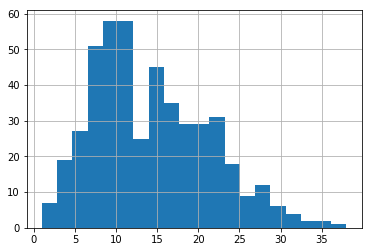

In [37]:
# Visualize distribution of the test set
mdf = pd.DataFrame()
mdf['temp'] = np.array(y_test_adj).squeeze()
print(mdf['temp'].describe())
mdf['temp'].hist(bins=20)

count    468.000000
mean      13.504971
std        3.573232
min        4.080896
25%       10.654010
50%       12.674493
75%       15.873813
max       35.844547
Name: temp, dtype: float64


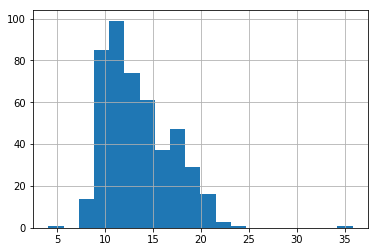

In [33]:
# Visualize distribution of predictions
mdf = pd.DataFrame()
mdf['temp'] = np.array(y_predicted_adj).squeeze()
print(mdf['temp'].describe())
mdf['temp'].hist(bins=20)

In [50]:
# Check regression
# MAE


# MSE


# R2



0.777081672961895

In [34]:
#Check performance of regression in bins 
#FOR DE-SCALED VALUES
CUTOFFS = [-900000000000000, 17, 9000000000000000]
y_test_categorized = []
y_predicted_categorized = []

df = pd.DataFrame(y_predicted_adj)
df[df.isna().any(axis=1)] = 20

for i in range(len(y_test_adj)):
    for ii in range(1,len(CUTOFFS)):
        if y_test_adj[i] >= CUTOFFS[ii-1] and y_test_adj[i] < CUTOFFS[ii]:
            this_label = [0 for x in range(1,len(CUTOFFS))]
            this_label[ii-1] = 1
            y_test_categorized.append(this_label)
        if y_predicted_adj[i][0] >= CUTOFFS[ii-1] and y_predicted_adj[i][0] < CUTOFFS[ii]:
            this_label = [0 for x in range(1,len(CUTOFFS))]
            this_label[ii-1] = 1
            y_predicted_categorized.append(this_label)
y_test_categorized = np.array(y_test_categorized)
y_predicted_categorized = np.array(y_predicted_categorized)

In [45]:
from sklearn.metrics import f1_score
# for x in range(3):
#     this_s = f1_score(y_test_categorized[:,x], y_predicted_categorized[:,x], pos_label=1)
#     print(this_s)
    
Y_test = np.argmax(y_test_categorized, axis=1)
Y_predicted = np.argmax(y_predicted_categorized, axis=1)
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
print(classification_report(Y_test, Y_predicted))
print(confusion_matrix(Y_test, Y_predicted))
print('accuracy: {}'.format(accuracy_score(Y_test, Y_predicted)))

              precision    recall  f1-score   support

           0       0.70      0.86      0.77       312
           1       0.49      0.28      0.36       156

   micro avg       0.66      0.66      0.66       468
   macro avg       0.60      0.57      0.57       468
weighted avg       0.63      0.66      0.63       468

[[267  45]
 [112  44]]
accuracy: 0.6645299145299145


SyntaxError: invalid syntax (<ipython-input-43-35ba2386ea85>, line 1)